In [1]:
# -*- coding: utf-8 -*-

In [2]:
import sys
sys.path.insert(0, '../lib')  # noqa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import pdb
from sklearn.metrics import *
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import itertools
import csv
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import softmax
from nolearn.lasagne import NeuralNet
from greedy_order import *

# Load dataset

In [7]:
practice_data = pd.read_csv( 
    'partners-dataset/u.practice_area', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['name', 'id'] )

In [8]:
partner_data_columns = np.append(
    ['partner_id', 'name', 'experience'], 
    practice_data['name'].values
)

In [13]:
partner_data = pd.read_csv(
    'partners-dataset/partners.item', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names = partner_data_columns,
    index_col = 'partner_id'
)

partner_data

,name,experience,Others,Banca,Competencia,Energia,Farma,Inmobiliario,Infraestructuras,Tech,M&A
partner_id,,,,,,,,,,,
1,Eva MartÃ­nez,15,0,0,0,0,0,0,0,0,1
2,Juan Carlos LÃ³pez,10,0,1,0,0,0,0,1,0,0
3,MarÃ­a Ãlvarez,20,0,1,0,0,0,1,0,1,0
4,Carmen Guijarro,30,1,0,0,1,0,1,1,0,0
5,JesÃºs Quintero,5,0,1,0,0,0,0,0,0,0
6,Roberto GarcÃ­a,25,0,1,0,0,0,1,1,0,0
7,Marina Gil,5,0,1,0,1,0,1,1,0,0
8,Javier SebastiÃ¡n,10,0,1,1,1,0,1,1,1,0
9,Teresa Herrera,25,0,0,0,1,1,1,1,0,0


In [14]:
selected_columns = np.append(['name', 'experience'], practice_data['name'].values)
partner_data = partner_data[selected_columns]

partner_data

,name,experience,Others,Banca,Competencia,Energia,Farma,Inmobiliario,Infraestructuras,Tech,M&A
partner_id,,,,,,,,,,,
1,Eva MartÃ­nez,15,0,0,0,0,0,0,0,0,1
2,Juan Carlos LÃ³pez,10,0,1,0,0,0,0,1,0,0
3,MarÃ­a Ãlvarez,20,0,1,0,0,0,1,0,1,0
4,Carmen Guijarro,30,1,0,0,1,0,1,1,0,0
5,JesÃºs Quintero,5,0,1,0,0,0,0,0,0,0
6,Roberto GarcÃ­a,25,0,1,0,0,0,1,1,0,0
7,Marina Gil,5,0,1,0,1,0,1,1,0,0
8,Javier SebastiÃ¡n,10,0,1,1,1,0,1,1,1,0
9,Teresa Herrera,25,0,0,0,1,1,1,1,0,0


# Remove null values

In [15]:
partner_data[selected_columns].isnull().any()

name                False
experience          False
Others              False
Banca               False
Competencia         False
Energia             False
Farma               False
Inmobiliario        False
Infraestructuras    False
Tech                False
M&A                 False
dtype: bool

In [ ]:
null_release_dates = movie_data[movie_data['release_date'].isnull()]
assert null_release_dates.shape[0] == 1

In [ ]:
movie_data = movie_data.drop(null_release_dates.index.values)
assert movie_data[selected_columns].isnull().any().any() == False

# Check data types

In [16]:
partner_data.dtypes

name                object
experience           int64
Others               int64
Banca                int64
Competencia          int64
Energia              int64
Farma                int64
Inmobiliario         int64
Infraestructuras     int64
Tech                 int64
M&A                  int64
dtype: object

# Compute the partner score and "fit_probability" attributes

In [32]:
new_offer = {
    'experience': 15,
    'Others': 0,
    'Banca': 1,
    'Competencia': 1,
    'Energia': 0,
    'Farma': 0,
    'Inmobiliario': 1,
    'Infraestructuras': 0,
    'Tech': 0,
    'M&A': 0
}

sum(new_offer.values()) - new_offer['experience']

3

In [35]:
scores = []
for index, partner in partner_data.iterrows():
    score = 0
    for field in new_offer:
        if field == 'experience':
            if new_offer[field] == partner[field]:
                score += 2
            elif new_offer[field] < partner[field]:
                score += 1
            continue
        if new_offer[field] and partner[field] == new_offer[field]:
            score += 1
    scores.append(score)

partner_data['score'] = scores
partner_data[['name', 'score']].sort_values(by=['score'], ascending=False)

,name,score
partner_id,,
3,MarÃ­a Ãlvarez,3
6,Roberto GarcÃ­a,3
8,Javier SebastiÃ¡n,3
10,Mario VelÃ¡zquez,3
1,Eva MartÃ­nez,2
4,Carmen Guijarro,2
7,Marina Gil,2
9,Teresa Herrera,2
2,Juan Carlos LÃ³pez,1


In [42]:
# Factor de normalizacion: #{area = 1 : area in practice_areas} + 2 (+2 por la maxima puntuacion que se puede conseguir por exp)
norm_factor = sum(new_offer.values()) - new_offer['experience'] + 2
# Probabilidad: 
partner_data['probability'] = partner_data['score'] / norm_factor

partner_data[['name', 'score', 'probability']].sort_values(by=['probability'], ascending=False)

,name,score,probability
partner_id,,,
3,MarÃ­a Ãlvarez,3,0.6
6,Roberto GarcÃ­a,3,0.6
8,Javier SebastiÃ¡n,3,0.6
10,Mario VelÃ¡zquez,3,0.6
1,Eva MartÃ­nez,2,0.4
4,Carmen Guijarro,2,0.4
7,Marina Gil,2,0.4
9,Teresa Herrera,2,0.4
2,Juan Carlos LÃ³pez,1,0.2


# The perfect ranking

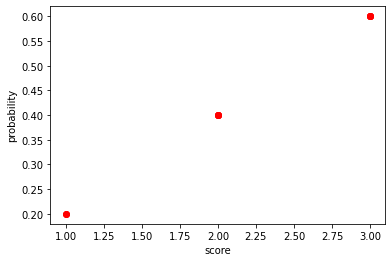

In [43]:
plt.plot(partner_data['score'].values, partner_data['probability'].values, 'ro') # ro = red circles
plt.xlabel('score')
plt.ylabel('probability')
plt.show()